In [1]:
%load_ext autoreload
%autoreload 2

In this example we are going to train 3 image classifiers using the [BigEarthNet](http://bigearth.net/) dataset:

1. Using S1 images
2. Using S2 images
3. Using both S1 and S2 images in a Data Fusion configuration.

## Sentinel 1

In [2]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.utils.sensors import Sensors, S1

ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=25, 
	bands={Sensors.S1: [S1.VH, S1.VV]}, # dict with sensor: bands
    verbose=True,
    label_groups=LABELS19
)

ds.setup()

Loading ... processed_S1_LABELS19.json
training samples 354196
validation samples 118065
test samples 118065


In [3]:
ds.df

,s1_images,labels,encoded_labels
0,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,"[Arable land, Pastures]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Permanent crops, Moors, heathland and sclerop...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
590321,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Arable land, Pastures, Land principally occup...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, ..."
590322,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,"[Arable land, Pastures, Agro-forestry areas]","[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
590323,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,"[Urban fabric, Industrial or commercial units,...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590324,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
ds.num_classes, ds.classes

(19,
 ['Urban fabric',
  'Industrial or commercial units',
  'Arable land',
  'Permanent crops',
  'Pastures',
  'Complex cultivation patterns',
  'Land principally occupied by agriculture, with significant areas of natural vegetation',
  'Agro-forestry areas',
  'Broad-leaved forest',
  'Coniferous forest',
  'Mixed forest',
  'Natural grassland and sparsely vegetated areas',
  'Moors, heathland and sclerophyllous vegetation',
  'Transitional woodland, shrub',
  'Beaches, dunes, sands',
  'Inland wetlands',
  'Coastal wetlands',
  'Inland waters',
  'Marine waters'])

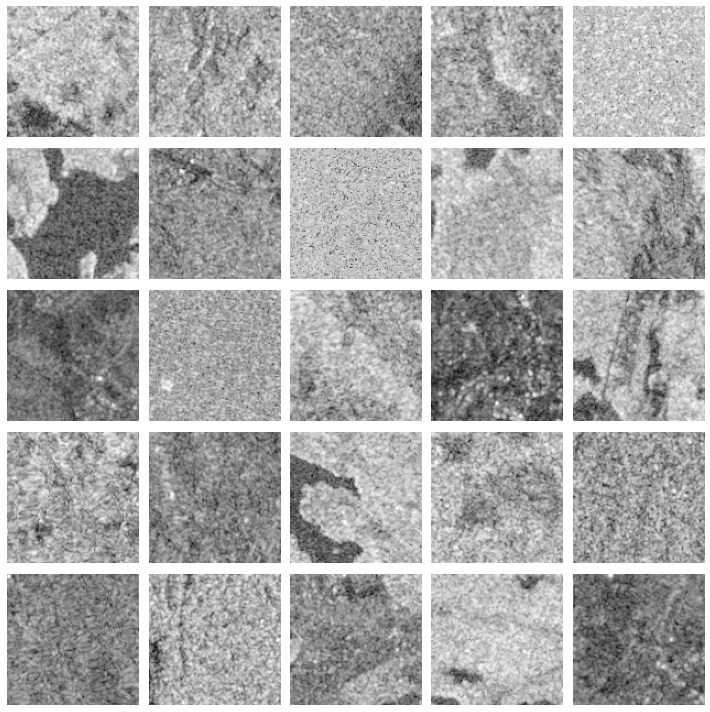

In [5]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['labels']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    # ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from einops import rearrange
import torch
import timm 

class Model(torch.nn.Module):

    def __init__(self, in_chans, num_classes, pretrained=None):
        super().__init__()
        self.model = timm.create_model(
            'resnet18',
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=num_classes
        )

    def forward(self, x):
        # here we have a tensor with dims (b h w c) and type float32 in db
        # resnet18 is a CNN that need channels first
        x = rearrange(x, 'b h w c -> b c h w')
        # undo dbs and clip range to 0-1
        x = 10**(x / 10)
        x = x.clip(0, 1)
        # now we can apply the model
        return self.model(x)

In [7]:
from pytorch_eo.tasks.classification import ImageMultilabelClassification

model = Model(in_chans=2, num_classes=ds.num_classes)

task = ImageMultilabelClassification(model)

out = task(imgs)

out.shape

torch.Size([25, 19])

In [8]:
import pytorch_lightning as pl
from sklearn.metrics import average_precision_score

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')


ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=32, 
	bands={Sensors.S1: [S1.VH, S1.VV]}, # dict with sensor: bands
    label_groups=LABELS19,
)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

metrics = {'map': my_map} 

task = ImageMultilabelClassification(model, hparams=hparams, metrics=metrics)

In [9]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
	limit_train_batches=30,
    limit_val_batches=10
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Loading ... processed_S1_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.732    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


## Sentinel 2

In [10]:
from pytorch_eo.utils.sensors import S2

ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=25, 
	bands={Sensors.S2: [S2.red, S2.green, S2.blue]}, # dict with sensor: bands
    verbose=True,
    label_groups=LABELS19
)

ds.setup()

Loading ... processed_S2_LABELS19.json
training samples 354196
validation samples 118065
test samples 118065


In [11]:
ds.df

,s2_images,labels,encoded_labels
0,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Coniferous forest, Mixed forest, Transitional...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."
1,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Arable land, Pastures, Broad-leaved forest]","[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Arable land, Pastures, Complex cultivation pa...","[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."
3,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Arable land, Coniferous forest, Mixed forest,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."
4,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Coniferous forest, Inland waters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...
590321,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,[Agro-forestry areas],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
590322,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Land principally occupied by agriculture, wit...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ..."
590323,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Coniferous forest, Mixed forest, Transitional...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ..."
590324,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


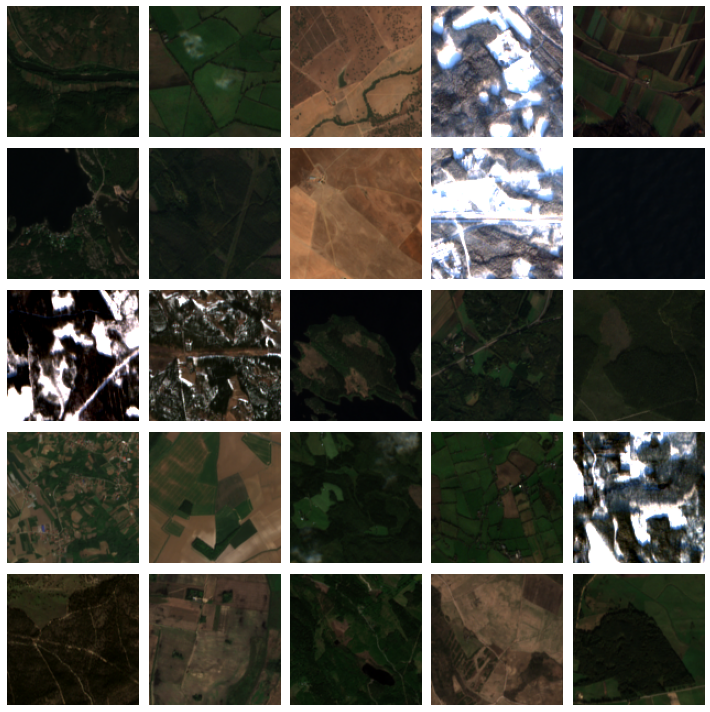

In [12]:
import matplotlib.pyplot as plt
from pytorch_eo.utils.image import to_uint8

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['labels']

fig = plt.figure(figsize=(10, 10))
th = 4000
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    img = to_uint8(img, 0, th)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        if img.size(-1) == 3:
            ax.imshow(img)
        else:
            ax.imshow(img[...,(3,2,1)]) # first band
    # ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
class Model(torch.nn.Module):

    def __init__(self, in_chans, num_classes, pretrained=None, max_value=4000):
        super().__init__()
        self.model = timm.create_model(
            'resnet18',
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=num_classes
        )
        self.max_value = max_value

    def forward(self, x):
        # here we have a tensor with dims (b h w c) and type float32 
        # resnet18 is a CNN that need channels first
        x = rearrange(x, 'b h w c -> b c h w')
        # undo dbs and clip range to 0-1
        x = x / self.max_value
        x = x.clip(0, 1)
        # now we can apply the model
        return self.model(x)

In [14]:
bands = [S2.red, S2.green, S2.blue]

ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=32, 
	bands={Sensors.S2: bands}, 
    label_groups=LABELS19,
)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

metrics = {'map': my_map} 

In [15]:
model = Model(in_chans=len(bands), num_classes=ds.num_classes)

task = ImageMultilabelClassification(model, hparams=hparams, metrics=metrics)

In [16]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
	limit_train_batches=30,
    limit_val_batches=10
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Loading ... processed_S2_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.745    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


## Data Fusion

In [17]:
ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=5, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    verbose=True
)

ds.setup()

Loading ... processed_S1_S2_LABELS19.json
training samples 354196
validation samples 118065
test samples 118065


In [18]:
ds.df

,s1_images,s2_images,labels,encoded_labels
0,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Arable land, Pastures]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Permanent crops, Moors, heathland and sclerop...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
590321,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Arable land, Pastures, Land principally occup...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, ..."
590322,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Arable land, Pastures, Agro-forestry areas]","[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
590323,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Urban fabric, Industrial or commercial units,...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590324,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


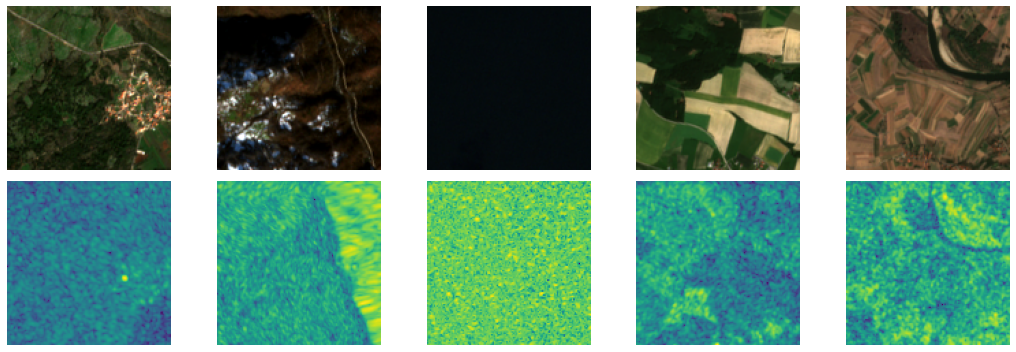

In [19]:
batch = next(iter(ds.train_dataloader()))

s1_imgs, s2_imgs, labels = batch['S1'], batch['S2'], batch['labels']

fig = plt.figure(figsize=(3*len(labels), 5))
th = 3000
for i, (s1, s2, label) in enumerate(zip(s1_imgs, s2_imgs, labels)):
	ax = plt.subplot(2, len(labels), i + 1)
	img = to_uint8(s2, 0, th)
	ax.imshow(img)
	ax.axis('off')
	ax = plt.subplot(2, len(labels), i + 1 + len(labels))
	ax.imshow(s1[...,0])
	ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
class Model(torch.nn.Module):

    def __init__(self, in_chans, num_classes, pretrained=None, max_value=4000):
        super().__init__()
        self.model = timm.create_model(
            'resnet18',
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=num_classes
        )
        self.max_value = max_value

    def forward(self, x):
        x1, x2 = x # S1, S2
        x1 = rearrange(x1, 'b h w c -> b c h w')
        x2 = rearrange(x2, 'b h w c -> b c h w')
        x1 = 10**(x1 / 10)
        x1 = x1.clip(0, 1)
        x2 = x2 / self.max_value
        x2 = x2.clip(0, 1)
        x = torch.cat([x1, x2], axis=1) # concatenate images on channels dimension
        return self.model(x)

In [21]:
ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=32, 
		bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

metrics = {'map': my_map} 

In [22]:
model = Model(in_chans=5, num_classes=ds.num_classes)

task = ImageMultilabelClassification(model, hparams=hparams, metrics=metrics, inputs=['S1', 'S2'])

In [23]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
	limit_train_batches=30,
    limit_val_batches=10
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Loading ... processed_S1_S2_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 11.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.770    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


## Filter clouds and snow

BigEarthNet has a list of images with clouds and snow. You can filter them out from the dataset like this (only works if S2 images are used).

In [24]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.utils.sensors import Sensors, S1, S2


ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=5, 
	bands={
        Sensors.S1: [S1.VH, S1.VV],     
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19,
    verbose=True,
	filter_snow=True, # will remove ~60k images
    filter_clouds=True # will remove ~10k images
)

ds.setup()

Loading ... processed_S1_S2_LABELS19.json
training samples 311605
validation samples 103867
test samples 103867


In [25]:
ds.df

,s1_images,s2_images,labels,encoded_labels
0,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Arable land, Pastures]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Permanent crops, Moors, heathland and sclerop...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
5,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Complex cultivation patterns, Transitional wo...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
6,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
590320,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Urban fabric, Arable land, Land principally o...","[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590321,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Arable land, Pastures, Land principally occup...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, ..."
590322,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Arable land, Pastures, Agro-forestry areas]","[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
590323,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Urban fabric, Industrial or commercial units,...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
